In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [48]:
data = pd.read_csv("./local_data/data_cleaned.csv")

In [49]:
numerical_data = data.filter(data.select_dtypes(["float64", "int64"]).columns)
numerical_data = numerical_data.fillna(numerical_data.median()).dropna(axis=1)
drop_cols = [
    "id",
    "host_id",
    "name",
    "neighbourhood_group",
    "neighbourhood",
    "last_review",
    "scrape_id",
    "price_per_person",
]
numerical_data = numerical_data.drop(columns=drop_cols, errors="ignore")
# numerical_data = numerical_data[
#     numerical_data["price"] < numerical_data["price"].quantile(0.99)
# ]

### transform features


In [50]:
numerical_data["number_of_reviews"]

0        0
1       52
2       21
3       33
4        0
        ..
2505    75
2506     0
2507    12
2508    43
2509     3
Name: number_of_reviews, Length: 2510, dtype: int64

In [51]:
correlation_matrix = numerical_data.filter(
    numerical_data.select_dtypes(["int64", "float64"]).columns
).corr()

In [52]:
col = "accommodates"
val = 0.95

numerical_data[numerical_data[col] >= numerical_data[col].quantile(val)].filter(
    ["price", col]
).corr()["price"]

price           1.000000
accommodates    0.100584
Name: price, dtype: float64

In [53]:
col = "bathrooms"
val = 0.99

numerical_data[numerical_data[col] >= numerical_data[col].quantile(val)].filter(
    ["price", col]
).corr()["price"]

price        1.000000
bathrooms    0.254857
Name: price, dtype: float64

In [54]:
col = "beds"
val = 0.9

numerical_data[numerical_data[col] >= numerical_data[col].quantile(val)].filter(
    ["price", col]
).corr()["price"]

price    1.000000
beds     0.046302
Name: price, dtype: float64

In [55]:
col = "bedrooms"
val = 0.95

numerical_data[numerical_data[col] >= numerical_data[col].quantile(val)].filter(
    ["price", col]
).corr()["price"]

price       1.000000
bedrooms    0.303475
Name: price, dtype: float64

In [56]:
col = "noise_night"
val = 0.95

numerical_data[numerical_data[col] >= numerical_data[col].quantile(val)].filter(
    ["price", col]
).corr()["price"]

price          1.000000
noise_night    0.058728
Name: price, dtype: float64

In [57]:
numerical_data.filter(numerical_data.select_dtypes(["int64", "float64"]).columns)

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,tourism_sportsactivitylocation,tourism_store,tourism_touristattraction,tourism_winery,tourism_zoo,tourism_total,tourism_points_within_radius,noise_day,noise_night,noise_points_within_radius
0,100.0,54.0,3,9,47.419450,8.51601,2,1.0,1.0,1.0,...,0.000000,0.000000,0.000003,0.0,0.000000,0.000246,3,3.374712,2.577530,10000
1,100.0,96.0,40,43,47.344800,8.53408,2,1.0,1.0,1.0,...,0.460126,0.000000,0.000016,0.0,0.000001,0.670397,26,2875.599597,2531.576653,10000
2,100.0,89.0,1,1,47.379020,8.51371,2,1.0,1.0,1.0,...,0.001430,0.001867,0.009909,0.0,0.000000,0.662180,137,152.654602,125.721843,10000
3,100.0,96.0,40,43,47.344920,8.53418,2,1.0,1.0,1.0,...,0.499659,0.000000,0.000018,0.0,0.000001,0.710986,26,1387.160614,1221.581287,10000
4,100.0,0.0,5,9,47.336021,8.53943,16,1.0,1.0,18.0,...,0.004629,0.000000,0.000000,0.0,0.000000,0.572463,13,1332.033165,1118.508709,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,99.0,88.0,36,38,47.374280,8.53891,2,1.0,0.0,1.0,...,0.154249,0.037199,1.584211,0.0,0.000071,15.201744,415,5600.983466,4938.868263,10000
2506,100.0,100.0,6,7,47.359330,8.59083,8,1.0,2.0,0.0,...,0.000314,0.000000,0.000000,0.0,0.000000,0.000530,4,1103.756677,861.725765,10000
2507,100.0,100.0,5,8,47.375950,8.54494,2,1.0,0.0,2.0,...,0.041689,0.094220,1.101255,0.0,0.000003,17.196670,386,5410.251446,4727.239770,10000
2508,90.0,100.0,1,2,47.373990,8.52341,2,1.0,0.0,1.0,...,0.001032,0.431306,0.000313,0.0,0.000002,3.829090,267,5781.274050,5019.691433,10000


In [58]:
np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.max_rows", None)
print(correlation_matrix["price"].sort_values(ascending=False, key=abs))

price                                           1.000000
accommodates                                    0.381031
bedrooms                                        0.354078
neighbourhood_cleansed__Lindenhof               0.307958
bathrooms                                       0.289664
beds                                            0.250835
tourism_restaurant                              0.245583
tourism_civicstructure                          0.244259
tourism_touristattraction                       0.230716
tourism_church                                  0.221765
tourism_total                                   0.204611
neighbourhood_group_cleansed__Kreis 1           0.193275
tourism_points_within_radius                    0.190672
distance_to_center_km                          -0.168745
tourism_museum                                  0.164663
room_type__Private room                        -0.154402
room_type__Entire home/apt                      0.153897
tourism_hotel                  

In [59]:
df_features = numerical_data.filter(
    numerical_data.select_dtypes(["int64", "float64"]).columns
)
# Berechnung von Skewness und Kurtosis für jedes Feature
from scipy.stats import skew, kurtosis

results = pd.DataFrame(
    {
        "Feature": df_features.columns,
        "Skewness": [
            (
                skew(df_features[col].dropna())
                if df_features[col].dtype in ["float64", "int64"]
                else None
            )
            for col in df_features.columns
        ],
        "Kurtosis": [
            (
                kurtosis(df_features[col].dropna())
                if df_features[col].dtype in ["float64", "int64"]
                else None
            )
            for col in df_features.columns
        ],
    }
)

# Ergebnisse anzeigen
print(results)

# Optional: Ergebnisse in eine CSV-Datei speichern
results.to_csv("local_data/skewness_kurtosis_results.csv", index=False)

                                          Feature   Skewness     Kurtosis
0                              host_response_rate  -3.344650    10.593310
1                            host_acceptance_rate  -1.510373     0.998573
2                             host_listings_count   2.629520     6.529149
3                       host_total_listings_count   2.390248     5.420054
4                                        latitude   0.376611    -0.027384
5                                       longitude   0.083494     0.074055
6                                    accommodates   2.156622     9.124530
7                                       bathrooms   3.623114    26.798649
8                                        bedrooms   1.786052     6.860490
9                                            beds   7.591550   143.529748
10                                          price   8.315836   109.599098
11                                 minimum_nights  18.979876   434.592676
12                                 max

In [60]:
# Find skewed numerical features
high_skew = results[abs(results["Skewness"]) > 0.5]
pd.set_option("display.max_rows", None)
pd.reset_option("display.max_rows")
list_high_skew = np.array(high_skew["Feature"]).tolist()
print(list_high_skew)

['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'host_experience_days', 'listing_age_days', 'days_since_last_review', 'neighbourhood_group_cleansed__Kreis 1', 'neighbourhood_group_cleansed__Kreis 10', 'neighbourhood_group_cleansed__Kreis 11', 'neighbourhood_group_cleanse

In [61]:
df_features.skew().abs().sort_values(ascending=False).tail(20)

room_type__Private room         1.347623
listing_age_days                1.345662
room_type__Entire home/apt      1.279399
tourism_points_within_radius    0.614168
availability_30                 0.611906
host_experience_days            0.527246
distance_to_center_km           0.461620
maximum_nights                  0.423268
availability_365                0.380956
latitude                        0.376836
availability_60                 0.328396
noise_night                     0.231786
availability_90                 0.207194
amenity_count                   0.171656
noise_day                       0.165911
longitude                       0.083544
minimum_maximum_nights          0.022499
tourism_winery                  0.000000
tourism_place                   0.000000
tourism_landform                0.000000
dtype: float64

In [62]:
# # creating dataframe with columns that need to be transformed

# df = numerical_data.filter([
#     [
#         "host_listings_count",
#         "host_total_listings_count",
#         "accommodates",
#         "bathrooms",
#         "bedrooms",
#         "beds",
#         "minimum_nights",
#         "minimum_minimum_nights",
#         "maximum_minimum_nights",
#         "maximum_maximum_nights",
#         "minimum_nights_avg_ntm",
#         "maximum_nights_avg_ntm",
#         "availability_30",
#         "availability_60",
#         "number_of_reviews",
#         "number_of_reviews_ltm",
#         "number_of_reviews_l30d",
#         "review_scores_rating",
#         "review_scores_accuracy",
#         "review_scores_cleanliness",
#         "review_scores_checkin",
#         "review_scores_communication",
#         "review_scores_location",
#         "review_scores_value",
#         "calculated_host_listings_count",
#         "calculated_host_listings_count_entire_homes",
#         "calculated_host_listings_count_private_rooms",
#         "calculated_host_listings_count_shared_rooms",
#         "reviews_per_month",
#         "host_experience_days",
#         "listing_age_days",
#         "days_since_last_review",
#         "price_per_person",
#         "tourism_barorpub",
#         "tourism_bedandbreakfast",
#         "tourism_cafeorcoffeeshop",
#         "tourism_campground",
#         "tourism_casino",
#         "tourism_church",
#         "tourism_civicstructure",
#         "tourism_dayspa",
#         "tourism_entertainmentbusiness",
#         "tourism_hostel",
#         "tourism_hotel",
#         "tourism_localbusiness",
#         "tourism_lodgingbusiness",
#         "tourism_movietheater",
#         "tourism_museum",
#         "tourism_musicvenue",
#         "tourism_nightclub",
#         "tourism_park",
#         "tourism_performingartstheater",
#         "tourism_publicswimmingpool",
#         "tourism_restaurant",
#         "tourism_shoppingcenter",
#         "tourism_sportsactivitylocation",
#         "tourism_store",
#         "tourism_touristattraction",
#         "tourism_zoo",
#         "tourism_total",
#         "tourism_points_within_radius",
#         "noise_points_within_radius",
#     ]
# ]

In [63]:
list_no_high_skew = [
    ele for ele in df_features.columns.tolist() if ele not in list_high_skew
]

In [64]:
# transformation
numerical_data_transformed = numerical_data.copy()
from sklearn.preprocessing import PowerTransformer, StandardScaler

power_scaler = PowerTransformer(method="yeo-johnson")
standard_scaler = StandardScaler()

list_no_high_skew = [
    ele for ele in df_features.columns.tolist() if ele not in list_high_skew
]
numerical_data_transformed.loc[:, list_high_skew] = power_scaler.fit_transform(
    numerical_data_transformed.loc[:, list_high_skew]
)
numerical_data_transformed.loc[:, list_no_high_skew] = standard_scaler.fit_transform(
    numerical_data_transformed.loc[:, list_no_high_skew]
)


print("DataFrame after Yeo-Johnson transformation")
numerical_data_transformed.to_csv(
    "local_data/numerical_data_transformed.csv", index=False
)
numerical_data_transformed

/Applications/anaconda3/envs/dsf/lib/python3.11/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Applications/anaconda3/envs/dsf/lib/python3.11/site-packages/numpy/_core/_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/var/folders/yj/d6dnn2c12fx2z9d89ztngqn00000gn/T/ipykernel_6549/2869111665.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.1998  1.2149 -0.9958 ...  0.1632 -0.9958 -0.5005]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  numerical_data_transformed.loc[:, list_high_skew] = power_scaler.fit_transform(
/var/folders/yj/d6dnn2c12fx2z9d89ztngqn00000gn/T/ipykernel_6549/2869111665.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

DataFrame after Yeo-Johnson transformation


,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,tourism_sportsactivitylocation,tourism_store,tourism_touristattraction,tourism_winery,tourism_zoo,tourism_total,tourism_points_within_radius,noise_day,noise_night,noise_points_within_radius
0,0.459323,-1.104380,-0.199850,0.330966,2.221909,-0.668393,-0.410186,-0.334292,-0.110545,-0.400713,...,-0.703610,-0.660144,-0.580194,0.0,-0.226461,-1.257536,-1.783535,-1.840723,-1.792344,0.019964
1,0.459323,0.565783,1.214940,1.106243,-1.814874,0.091874,-0.410186,-0.334292,-0.110545,-0.400713,...,2.317449,-0.660144,-0.579781,0.0,-0.218397,-0.133625,-0.904136,-0.341719,-0.238213,0.019964
2,0.459323,0.250020,-0.995811,-1.153531,0.035611,-0.765162,-0.410186,-0.334292,-0.110545,-0.400713,...,-0.562772,-0.549832,-0.270954,0.0,-0.226461,-0.142407,0.281355,-1.762814,-1.716669,0.019964
3,0.459323,0.565783,1.214940,1.106243,-1.808385,0.096081,-0.410186,-0.334292,-0.110545,-0.400713,...,2.317454,-0.660144,-0.579722,0.0,-0.217561,-0.091353,-0.904136,-1.118530,-1.043236,0.019964
4,0.459323,-2.238686,0.163176,0.330966,-2.289591,0.316966,2.995823,-0.334292,-0.110545,4.363698,...,-0.271776,-0.660144,-0.580307,0.0,-0.226461,-0.243621,-1.256732,-1.147301,-1.106577,0.019964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,0.321995,0.206064,1.178698,1.057609,-0.220710,0.295089,-0.410186,-0.334292,-2.256414,-0.400713,...,2.292378,0.870438,2.474344,0.0,0.185710,1.742129,1.419593,1.080649,1.241126,0.019964
2506,0.459323,0.752454,0.284781,0.173427,-1.029148,2.479542,2.122682,-0.334292,1.233111,-2.567709,...,-0.672069,-0.660144,-0.580307,0.0,-0.226461,-1.256780,-1.701768,-1.266438,-1.264376,0.019964
2507,0.459323,0.752454,0.163176,0.258181,-0.130402,0.548792,-0.410186,-0.334292,-2.256414,0.688210,...,1.545295,1.753566,2.473464,0.0,-0.208196,1.774874,1.334686,0.981107,1.111076,0.019964
2508,-0.739438,0.752454,-0.995811,-0.693766,-0.236392,-0.357050,-0.410186,-0.334292,-2.256414,-0.400713,...,-0.601254,2.166322,-0.569982,0.0,-0.213342,1.143551,0.926703,1.174742,1.290794,0.019964


In [65]:
# def transform_features(df: pd.DataFrame) -> pd.DataFrame:
#     transformed_df = df.copy()

#     numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
#     if "price" in numeric_cols:
#         numeric_cols.remove("price")

#     sqrt_df = df[numeric_cols].apply(lambda x: np.sqrt(x - x.min() + 1))
#     sqrt_df.columns = [f"sqrt_{col}" for col in numeric_cols]

#     log_df = df[numeric_cols].apply(lambda x: np.log(x - x.min() + 1))
#     log_df.columns = [f"log_{col}" for col in numeric_cols]

#     # winsorisation
#     wins_df = df[numeric_cols].apply(
#         lambda x: stats.mstats.winsorize(x, limits=[0.023, 0.023])
#     )
#     wins_df.columns = [f"wins_{col}" for col in numeric_cols]

#     return pd.concat([transformed_df, sqrt_df, log_df, wins_df], axis=1)


# numerical_data_transformed = transform_features(numerical_data)

In [66]:
X = numerical_data_transformed.drop("price", axis=1)
y = numerical_data["price"]

In [67]:
numerical_data_transformed.sort_values("price", ascending=False).head(20)

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,tourism_sportsactivitylocation,tourism_store,tourism_touristattraction,tourism_winery,tourism_zoo,tourism_total,tourism_points_within_radius,noise_day,noise_night,noise_points_within_radius
2384,-0.739438,0.752454,0.008071,-0.203545,-0.298579,0.343053,1.677661,2.090430,2.228352,1.390446,...,2.146874,0.524251,2.474393,0.0,0.627641,1.831616,1.422442,0.210076,0.205219,0.019964
1224,-3.030885,-2.238686,-0.500505,-0.049582,-0.403487,0.388913,0.969656,-2.881108,1.233111,-0.400713,...,2.187626,0.624396,2.474380,0.0,1.737670,1.862781,1.408148,2.043048,1.899844,0.019964
2383,-0.739438,0.752454,0.008071,-0.203545,-0.298579,0.343053,1.677661,2.090430,2.228352,1.390446,...,2.146874,0.524251,2.474393,0.0,0.627641,1.831616,1.422442,0.210076,0.205219,0.019964
2387,-0.739438,0.752454,0.008071,-0.203545,-0.298579,0.343053,1.677661,2.090430,2.228352,1.390446,...,2.146874,0.524251,2.474393,0.0,0.627641,1.831616,1.422442,0.210076,0.205219,0.019964
1923,0.459323,0.752454,0.008071,-0.203545,-1.885112,-0.032129,2.433946,3.614747,3.692874,2.290509,...,1.750679,-0.660144,-0.580200,0.0,-0.226461,-1.024393,-0.971864,-0.837226,-0.765774,0.019964
505,-1.599299,-0.338256,0.383536,0.173427,-0.579891,0.358918,1.677661,3.614747,3.692874,-2.567709,...,2.317454,-0.387090,2.472884,0.0,6.054452,1.629838,1.387919,0.389691,0.509622,0.019964
320,0.459323,0.612031,-0.995811,-1.153531,-0.933433,0.716665,0.969656,-0.334292,-0.110545,-0.400713,...,1.345011,2.016978,1.448075,0.0,-0.017894,1.262828,1.029563,0.935042,1.033077,0.019964
308,-0.418851,0.752454,0.967219,0.944130,-0.969664,-0.423526,2.122682,3.614747,-0.110545,1.898169,...,2.069696,-0.656256,-0.580034,0.0,-0.097941,-0.417545,0.006008,1.165742,1.260536,0.019964
388,0.459323,0.658559,0.596515,0.394438,-0.881309,0.693297,1.922239,1.137695,2.228352,1.390446,...,2.054509,2.101920,2.193273,0.0,0.103077,1.458699,1.094320,-0.148159,-0.108581,0.019964
1500,0.459323,0.338803,0.163176,0.258181,-2.191785,0.311497,1.677661,3.242245,2.228352,1.390446,...,0.632770,-0.660144,-0.580307,0.0,-0.226461,-0.507387,-1.222450,-0.879580,-0.832644,0.019964


In [68]:
y.describe()

count    2510.000000
mean      176.759761
std       185.586163
min        21.000000
25%        98.000000
50%       138.000000
75%       194.000000
max      3540.000000
Name: price, dtype: float64

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=99
)


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [70]:
cv = KFold(n_splits=5, shuffle=True, random_state=99)

In [71]:
lasso_cv = LassoCV(
    cv=cv,
    random_state=99,
    max_iter=100000,
    alphas=np.logspace(-2, 3, 100),
    selection="random",
    tol=1e-3,
    fit_intercept=True,
)

lasso_cv.fit(X_train_scaled, y_train)

LassoCV(alphas=array([   0.01  ,    0.0112,    0.0126,    0.0142,    0.0159,    0.0179,
          0.0201,    0.0226,    0.0254,    0.0285,    0.032 ,    0.0359,
          0.0404,    0.0453,    0.0509,    0.0572,    0.0643,    0.0722,
          0.0811,    0.0911,    0.1024,    0.115 ,    0.1292,    0.1451,
          0.163 ,    0.1831,    0.2057,    0.231 ,    0.2595,    0.2915,
          0.3275,    0.3678,    0.4132,    0.4642,    0.5214,    0.5857,
          0.6579,    0.7391,    0.8302,    0.9326,    1.0476,    1.1768,
          1.3219,    1.485 ,    1.6681,    1.8738,    2.1049,    2.3645...
         43.2876,   48.626 ,   54.6228,   61.3591,   68.9261,   77.4264,
         86.9749,   97.701 ,  109.7499,  123.2847,  138.4886,  155.5676,
        174.7528,  196.3041,  220.5131,  247.7076,  278.2559,  312.5716,
        351.1192,  394.4206,  443.0621,  497.7024,  559.081 ,  628.0291,
        705.4802,  792.4829,  890.2151, 1000.    ]),
        cv=KFold(n_splits=5, random_state=99, shuffle=True), max_iter=100000,
        random_state=99, selection='random', tol=0.001)

Best regularization parameter: 0.59


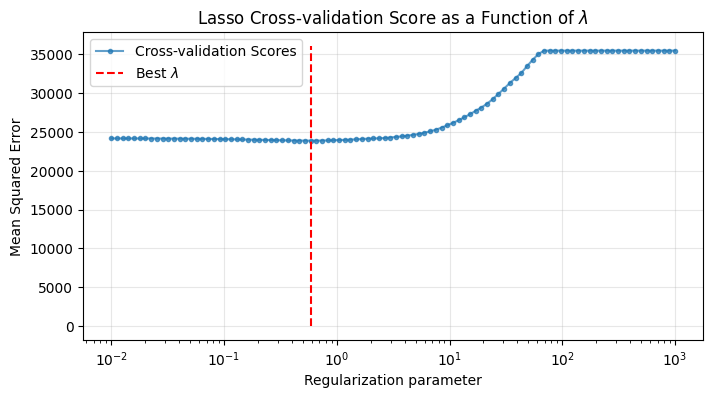

In [72]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=1),
    marker="o",
    markersize=3,
    alpha=0.7,
    label="Cross-validation Scores",
)
# Plot the final chosen regularization parameter
ax.vlines(
    lasso_cv.alpha_,
    0,
    ax.get_ylim()[1],
    linestyle="--",
    color="red",
    label=r"Best $\lambda$",
)

# Aesthetics
ax.set_xscale("log")
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Mean Squared Error")
ax.set_title(r"Lasso Cross-validation Score as a Function of $\lambda$")
ax.grid(alpha=0.3)
ax.legend()

print(f"Best regularization parameter: {lasso_cv.alpha_:.2f}")

In [73]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray, dataset_name: str) -> None:
    """"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")


y_train_pred = lasso_cv.predict(X_train_scaled)
y_test_pred = lasso_cv.predict(X_test_scaled)


evaluate_model(y_train, y_train_pred, "train")
evaluate_model(y_test, y_test_pred, "test")


train Metrics:
R² Score: 0.4198
RMSE: 143.31
MAE: 75.34

test Metrics:
R² Score: 0.2588
RMSE: 150.02
MAE: 72.45


\coeffs:
                                             feat       coeff
16                         minimum_nights_avg_ntm -110.754674
13                         maximum_minimum_nights   60.953113
72              neighbourhood_cleansed__Lindenhof   39.546059
33    calculated_host_listings_count_entire_homes  -33.013495
6                                    accommodates   32.900582
8                                        bedrooms   31.471676
7                                       bathrooms   26.437398
1                            host_acceptance_rate   21.581152
22                              number_of_reviews  -20.985374
21                               availability_365   20.052577
19                                availability_60   15.029707
2                             host_listings_count   14.801648
90                        room_type__Private room  -14.033800
14                         minimum_maximum_nights   13.318879
9                                            beds   12.890259

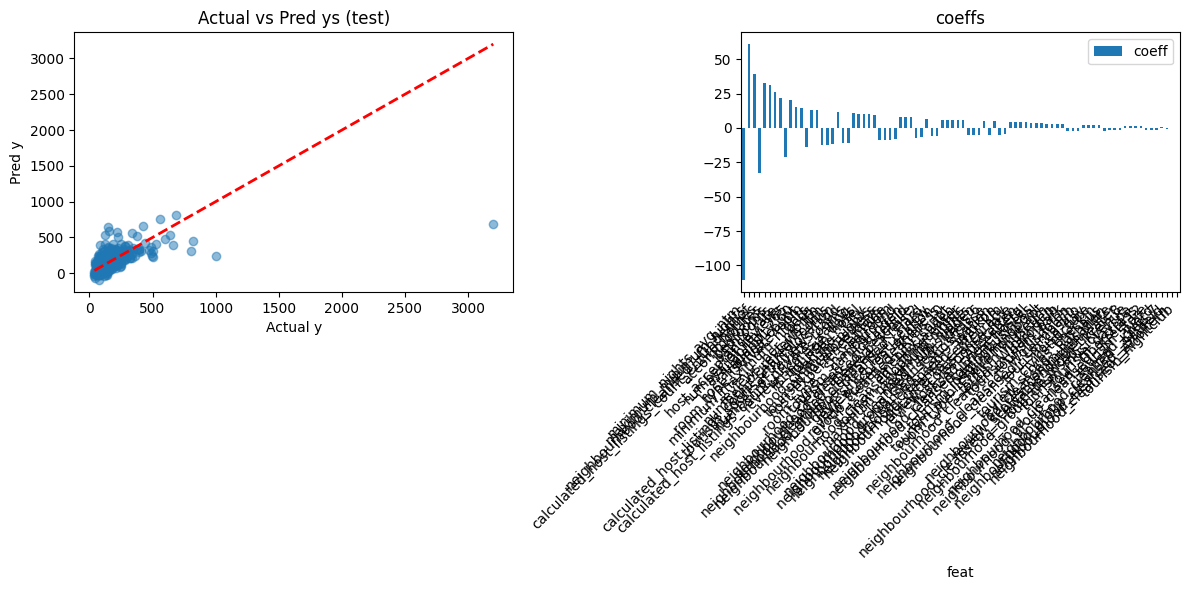

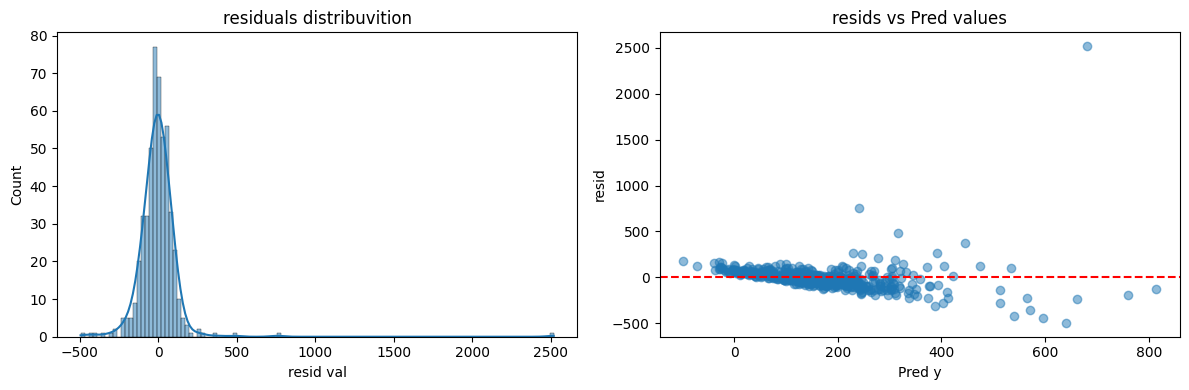

In [74]:
feature_importance = pd.DataFrame({"feat": X.columns, "coeff": lasso_cv.coef_})

feature_importance["Abs_coeff"] = abs(feature_importance["coeff"])
feature_importance_sorted = feature_importance.sort_values("Abs_coeff", ascending=False)
non_zero_features = feature_importance_sorted[feature_importance_sorted["coeff"] != 0]

print(r"\coeffs:")
print(non_zero_features[["feat", "coeff"]].to_string())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual y")
plt.ylabel("Pred y")
plt.title("Actual vs Pred ys (test)")

# Plot 2: feat coeffs
plt.subplot(1, 2, 2)
non_zero_features.plot(kind="bar", x="feat", y="coeff", ax=plt.gca())
plt.xticks(rotation=45, ha="right")
plt.title("coeffs")
plt.tight_layout()
plt.show()

residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("residuals distribuvition")
plt.xlabel("resid val")

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Pred y")
plt.ylabel("resid")
plt.title("resids vs Pred values")
plt.tight_layout()
plt.show()

In [75]:
coefficient_df = pd.DataFrame(
    {
        "feature": X.columns,
        "coeff": lasso_cv.coef_,
        "coeff_abs": abs(lasso_cv.coef_),
    }
)

coefficient_df = coefficient_df.sort_values("coeff_abs", ascending=False)
coefficient_df

,feature,coeff,coeff_abs
16,minimum_nights_avg_ntm,-110.754674,110.754674
13,maximum_minimum_nights,60.953113,60.953113
72,neighbourhood_cleansed__Lindenhof,39.546059,39.546059
33,calculated_host_listings_count_entire_homes,-33.013495,33.013495
6,accommodates,32.900582,32.900582
...,...,...,...
83,neighbourhood_cleansed__Weinegg,-0.000000,0.000000
20,availability_90,-0.000000,0.000000
93,tourism_bedandbreakfast,-0.000000,0.000000
94,tourism_cafeorcoffeeshop,0.000000,0.000000


## RF


In [76]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor


def perform_rf(X_train_scaled, y_train):
    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=99,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
    )

    rf.fit(X_train_scaled, y_train)

    return rf


def evaluate_rf(rf, y_true, y_pred, dataset_name: str):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{dataset_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": rf.feature_importances_}
    ).sort_values("importance", ascending=False)

    return mse, rmse, mae, r2, feature_importance


def visualize_rf_performance(y_true, y_pred, feature_importance):
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))

    # Scatter, actual vs predicted
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 0].plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", lw=2
    )
    axes[0, 0].set_title("Actual vs Predicted Values")
    axes[0, 0].set_xlabel("Actual Values")
    axes[0, 0].set_ylabel("Predicted Values")

    # feature_importance bar chart (top 10)
    top_features = feature_importance.head(10)
    sns.barplot(x="importance", y="feature", data=top_features, ax=axes[1, 0])
    axes[0, 1].set_title("Top 10 Most Important Features")
    axes[0, 1].set_xlabel("Feature Importance")

    plt.tight_layout()
    plt.show()

train Metrics:
R² Score: 0.6595
MSE: 12052.54
RMSE: 109.78
MAE: 40.96
test Metrics:
R² Score: 0.3564
MSE: 19541.16
RMSE: 139.79
MAE: 56.99


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

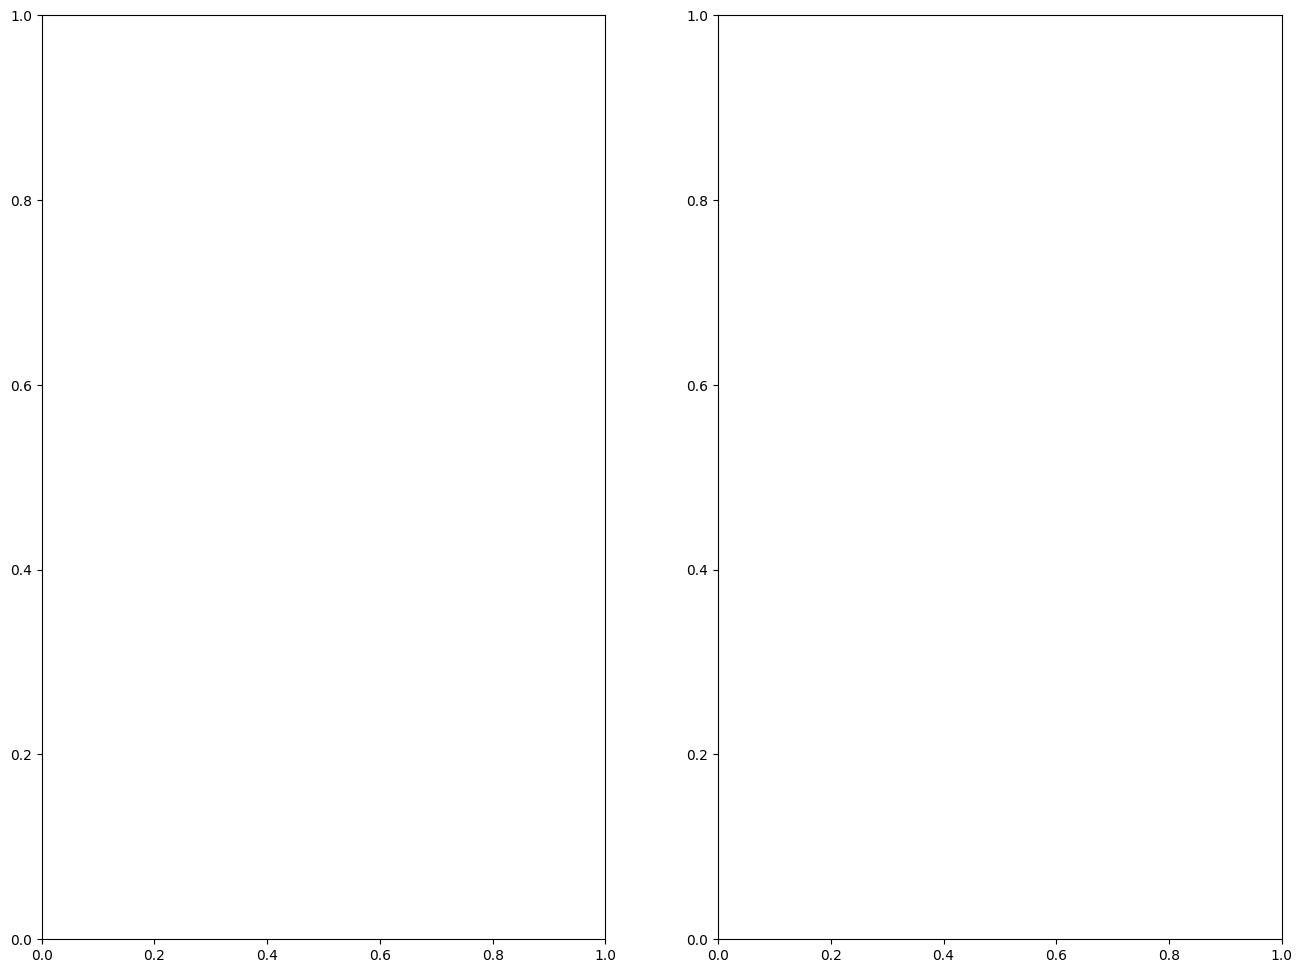

In [78]:
# Random forest

rf = perform_rf(X_train_scaled, y_train)  # fit random forest model

y_train_pred_rf = rf.predict(X_train_scaled)  # make predictions
y_test_pred_rf = rf.predict(X_test_scaled)

evaluate_rf(
    rf, y_train, y_train_pred_rf, "train"
)  # evaluate with MSE etc. and show most important features
evaluate_rf(rf, y_test, y_test_pred_rf, "test")

visualize_rf_performance(
    y_train, y_train_pred_rf, feature_importance
)  # create scatter plot with actual vs predicted data, plot bar chart with most important features, or use Y_TEST_PRED_RF TO VISUALISE